In [1]:
import random
import torch
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.regression.basic_due import train_due
from coati.utils.chem_explore import embed_and_score_in_batches_regression
import argparse
import os.path as osp
from coati.utils.chem import read_sdf, write_sdf, read_pkl, write_pkl, read_txt
from rdkit import Chem
from sklearn.metrics import r2_score

def clean_smiles(smiles):
    cleaned = smiles.replace('[C]', 'C').replace('[O]', 'O').replace('[N]', 'N').replace('[F]', 'F').replace('[Br]', 'Br')
    cleaned = cleaned.replace('[c]', 'c').replace('[n]', 'n').replace('[o]', 'o').replace('[s]', 's')
    return cleaned

def convert_mols(mols_list):
    normal_smiles = []
    for mol in mols_list:
        try:
            smi = Chem.MolToSmiles(mol)
            cleaned_smi = clean_smiles(smi)
            mol = Chem.MolFromSmiles(cleaned_smi)
            if mol is not None:
                normal_smi = Chem.MolToSmiles(mol)
                normal_smiles.append(normal_smi)
            else:
                normal_smiles.append(None)
        except Exception as e:
            normal_smiles.append(None)
            print(f"Error processing SMILES '{smi}': {e}")
    return normal_smiles

def rdkit_smi(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        normal_smi = Chem.MolToSmiles(mol)
        return normal_smi
    else:
        return None

def token_clean(smiles_list, tokenizer):
    clean_smiles = []
    for smi in smiles_list:
        try:
            if smi != "*":
                tokenizer.tokenize_text("[SMILES]" + smi + "[STOP]", pad=True)
                clean_smiles.append(smi)
        except Exception as e:
            print(f"Error tokenize SMILES '{smi}'")
    return clean_smiles

In [45]:
arg_parser = argparse.ArgumentParser(description='Train a model on the chemical space')
arg_parser.add_argument('--device', choices=['cuda:0', 'cpu'], \
    default='cuda:0',help='Device')
arg_parser.add_argument('--seed', type=int, default=2024) 
arg_parser.add_argument('--ecloudgen_ckpt', type=str, default = 'model_ckpts/ecloud_augmented_37.pkl')
arg_parser.add_argument('--train_smiles', type=str, default='./examples/conditions/target_ic50/fgfr_rela_424.txt')
arg_parser.add_argument('--task', type=str, default='logp')
arg_parser.add_argument('--ckpt_dir', type=str, default='model_ckpts')
args = arg_parser.parse_args([])


In [46]:
# model define
DEVICE = args.device
encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=DEVICE,
    # model parameters to load.
    doc_url=args.ecloudgen_ckpt,
)

Loading model from model_ckpts/ecloud_augmented_37.pkl
Loading tokenizer mar from model_ckpts/ecloud_augmented_37.pkl
number of parameters: 12.64M
number of parameters Total: 2.44M xformer: 19.60M Total: 22.04M 
Freezing encoder
44882816 params frozen!


In [47]:
regen = False
cached = args.train_smiles[:-4] + "_cached.pt"
cached = '/home/haotian/Molecule_Generation/MG/backupECloud/EcloudGen-COATI/model_ckpts/conditions/fgfr_rela_424_data.pt'
if not osp.exists(cached) or regen:
    chem_data = read_txt(args.train_smiles)
    smi_pic50 = [(x.split(',')[0], float(x.split(',')[1])) for x in chem_data]
    subset = []
    for x in smi_pic50:
        mol = Chem.MolFromSmiles(x[0])
        if mol is not None:
            subset.append({"smiles": x[0], "pic50": x[1]})
        else:
            print(f"Error processing SMILES '{x[0]}'")
    embed_and_score_in_batches_regression(subset, encoder, tokenizer)
    clean_subset = []
    for x in subset:
        try:
            x["emb_smiles"]
            clean_subset.append(x)
        except:
            print(f"Error processing SMILES '{x['smiles']}'")
    torch.save(clean_subset, cached)
    print('Successfully processing ',len(clean_subset), ' Mols')
else:
    print(f"Loading cached data from {cached}")
    subset = torch.load(cached)


Embedding and scoring iterable from smiles.


4batch [00:01,  2.25batch/s]                    

Successfully processing  424  Mols


In [7]:
args.task = 'docking'

model_name = osp.join(args.ckpt_dir, osp.basename(args.train_smiles)[:-4] + f"_{args.task}.pt")
model_saved = osp.join(args.ckpt_dir, "target_"+args.task+".pt")
qsar_model, qsar_res = train_due(
    subset,
    x_field="emb_smiles",
    y_field=args.task,
    save_as= model_name,
    continue_training=False,
    steps=1e4,
    random_seed=2023
    )
qed_model = qsar_model.to(DEVICE)

Training with 242 datapoints for 10001.0 epochs
Results - Epoch: 1001 - Test Likelihood: 2.44 - Loss: 2.03


In [59]:
import matplotlib.pyplot as plt

def get_due_plot(due_result, y_field="qed", save_name="regression_plot.png"):
    """Plots the DUE model regressed results."""

    # xs are the true values, ys are the predicted values, dys are the errors.
    xs, ys, dys = due_result

    fig, ax = plt.subplots(figsize=(11, 6))
    n_to_plot = 30000
    # plt.style.use("seaborn-v0_8-pape")
    ax.errorbar(
        (xs[:n_to_plot]),
        (ys[:n_to_plot]),
        yerr=dys[:n_to_plot],
        fmt="o",
        color="black",
        ecolor="lightgray",
        elinewidth=3,
        capsize=0,
    )
    plt.xlabel("True " + y_field)
    plt.ylabel("Regressed " + y_field)
    plt.savefig(save_name)

In [60]:
xs, ys, _ = qsar_res

print('R2: '+str(r2_score(xs,ys)))

R2: 0.4423177747033662


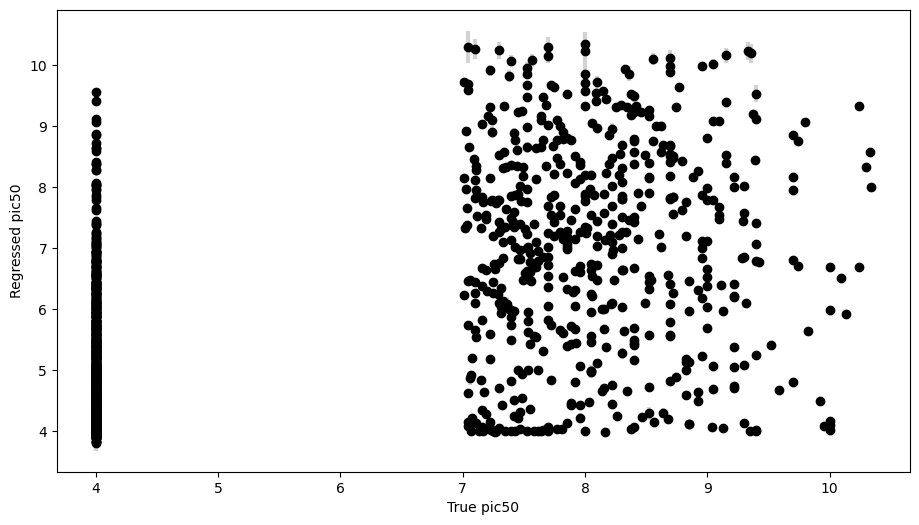

In [61]:
get_due_plot(qsar_res, y_field=args.task, save_name=args.task+"_regression_plot.png")